In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from sklearn.metrics import accuracy_score,classification_report
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy,mean_squared_error,mean_absolute_error
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
lenc = LabelEncoder()
ohe = OneHotEncoder()
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
N_CLASSES = 5
IMSIZE = (128,128,3)
INPUT_SIZE = 1000

In [3]:
def finetuned_inceptionresnet(include_top=False):
    base_model = InceptionResNetV2(include_top=include_top,input_shape=IMSIZE,weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='relu')(x)

    if not include_top:
        x = Dense(N_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(),loss=BinaryCrossentropy(from_logits=False),metrics=Accuracy())

    return model

In [7]:
DATA_DIR = 'data'
IMAGE_DIR = f'../{DATA_DIR}/dataset'

image_generator = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=augmentation_config['rotation_range'],
    # width_shift_range=augmentation_config['width_shift_range'],
    # height_shift_range=augmentation_config['height_shift_range'],
    # shear_range=augmentation_config['shear_range'],
    # zoom_range=augmentation_config['zoom_range'],
    # horizontal_flip=augmentation_config['horizontal_flip'],
    )
image_data = image_generator.flow_from_directory(
    IMAGE_DIR,
    target_size=(128,128),
    batch_size=256,
    class_mode='categorical',
)

Found 5180 images belonging to 5 classes.


In [10]:
inception_model = finetuned_inceptionresnet()


In [6]:
# X,Y = np.array(Data.drop(columns="classes")).reshape(-1,128,128,3), ohe.fit_transform(np.array(Data.classes).reshape(-1,1)).toarray()
# xtrain,xtest,ytrain,ytest = train_test_split(X,Y,train_size=0.8)
# del X,Y,Data


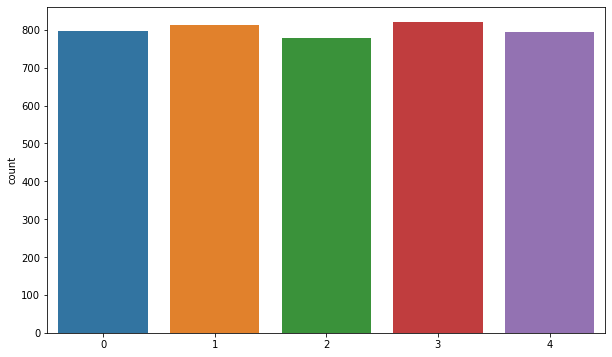

In [9]:
y = ohe.inverse_transform(ytrain)

plt.figure("countplot",figsize=(10,6))
sns.countplot(x=y.flatten())
plt.show()

In [12]:
inception_model.optimizer.learning_rate = 0.001

inception_model.fit(image_data,epochs=20)


Epoch 1/20
21/21 [==============================] - 26s 1s/step - loss: 0.0413 - accuracy: 0.7674
Epoch 2/20
21/21 [==============================] - 26s 1s/step - loss: 0.0277 - accuracy: 0.7705
Epoch 3/20
21/21 [==============================] - 26s 1s/step - loss: 0.0265 - accuracy: 0.7654
Epoch 4/20
21/21 [==============================] - 26s 1s/step - loss: 0.0204 - accuracy: 0.7644
Epoch 5/20
21/21 [==============================] - 26s 1s/step - loss: 0.0205 - accuracy: 0.7635
Epoch 6/20
21/21 [==============================] - 26s 1s/step - loss: 0.0184 - accuracy: 0.7627
Epoch 7/20
 2/21 [=>............................] - ETA: 24s - loss: 0.0181 - accuracy: 0.7777

In [ ]:
res = inception_model.predict(xtest).round(1)

In [ ]:
res_f = ohe.inverse_transform(res)
ytest_f = ohe.inverse_transform(ytest)

In [ ]:
print(classification_report(res_f,ytest_f))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       217
           1       0.97      0.97      0.97       197
           2       1.00      0.96      0.98       193
           3       0.97      0.97      0.97       192
           4       0.99      1.00      1.00       201

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



: 